In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import glob, os
import torch
import numpy as np

import seaborn as sns
import config_matplotlib
config_matplotlib.config_matplotlib()


registered cmap: seaborn_cubehelix



In [2]:
summary_yaml = '/pscratch/sd/z/zhantao/inxs_steering_production/benchmarks/summary.yaml'
import yaml

with open(summary_yaml, 'r') as file:
    summary_dict = yaml.safe_load(file)


In [3]:
steps_of_interest = [25, 50]

In [4]:
mean_preds = []
true_values = []
sample_ids = []
maes = []


measured_angles = []
method = 'poisson_scaledLkhd_unscaledUF'

for path in summary_dict['real'][method]:
    pt_flist = glob.glob(os.path.join(summary_dict['path'], path, '*.pt'))
    pt_indices = sorted([int(_.split('/')[-1].split('.')[0]) for _ in pt_flist])

    for _idx, _idx in enumerate(pt_indices):
        _pt = torch.load(os.path.join(summary_dict['path'], path, f'{_idx:02d}.pt'))
        # print(_pt.keys())
        _mean_preds = (_pt['positions'] * _pt['weights'].unsqueeze(-1)).sum(dim=-2) / _pt['weights'].sum(dim=-1).unsqueeze(-1)
        
        # _mean_preds = _pt['means']
        
        # _maes = (_mean_preds - _pt['true_params'][None]).norm(dim=-1)
        # maes.append(_maes[steps_of_interest].unsqueeze(0))
        _maes = (_mean_preds - _pt['true_params'][None])[-1,None].abs()
        
        maes.append(_maes)
        mean_preds.append(_mean_preds.unsqueeze(0))
        sample_ids.append(_idx)
        true_values.append(_pt['true_params'])
        measured_angles.append(_pt['measured_angles'].unsqueeze(0))
        
maes = torch.vstack(maes).numpy()
mean_preds = torch.vstack(mean_preds).numpy()
sample_ids = torch.tensor(sample_ids).numpy()
true_values = torch.vstack(true_values).numpy()
measured_angles = torch.vstack(measured_angles).numpy()

Text(6.472222222222223, 0.5, 'Mean Absolute Error (MAE)')

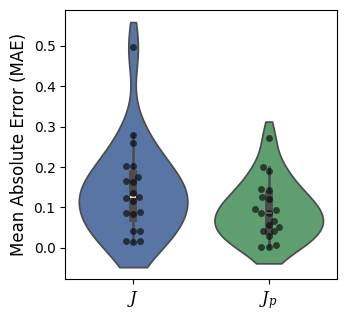

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
sns.violinplot(data=maes, ax=ax, cut=True)
sns.swarmplot(data=maes, ax=ax, color='black', alpha=0.6)
ax.set_xticks([0, 1])
ax.set_xticklabels(['$J$', '$J_{p}$'], fontsize=12)
ax.set_ylabel('Mean Absolute Error (MAE)')

In [6]:
import sys
sys.path.append('../')

from inxss import SpecNeuralRepr
from inxss.steer_neutron import NeutronExperimentSteerer

In [7]:
import hydra
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra

GlobalHydra.instance().clear()

with initialize(config_path="../conf/final"):
    cfg = compose(config_name="config_gaussian")
    
model_path = cfg['paths']['model_path']
data = torch.load(cfg['paths']['data_path'])

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/tmp/ipykernel_863333/2738538312.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../conf/final"):


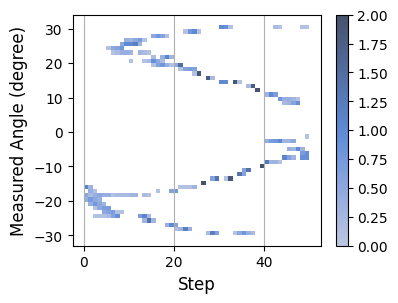

In [8]:
measured_angles_y_hist = []
measured_angles_x_hist = []

fig, ax_ang = plt.subplots(1, 1, figsize=(4, 3))

measured_angles_demo = measured_angles
measured_angles_demo[measured_angles_demo > 180] -= 360
measured_angles_x_hist += np.repeat(np.linspace(0,50,50)[None,:], 20, axis=0).reshape(-1).tolist()
measured_angles_y_hist += measured_angles_demo.reshape(-1).tolist()

hist_plot_out = sns.histplot(x=measured_angles_x_hist, y=measured_angles_y_hist, stat='percent',
                             bins=50, ax=ax_ang, color=f'C0', cbar=True)
# ax_ang.hist2d(measured_angles_x_hist, measured_angles_y_hist, bins=50, cmap='Blues')
ax_ang.set_xlabel('Step')
ax_ang.set_ylabel('Measured Angle (degree)')

ax_ang.xaxis.grid(True, which='both')

fig.savefig('figures/exp_benchmark_angle_hist_unscaledUF.pdf', bbox_inches='tight')